<a href="https://colab.research.google.com/github/intimanjunath/Clustering/blob/main/h_clustering_with_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorchvideo

In [2]:
import pytorchvideo
print("PyTorchVideo installed successfully!")

PyTorchVideo installed successfully!


In [3]:
# Clone the ImageBind repository
!git clone https://github.com/facebookresearch/ImageBind.git

# Navigate to the ImageBind directory
%cd ImageBind

# Install required dependencies
!pip install -r requirements.txt

# Install additional dependencies manually
!pip install pytorchvideo timm==0.6.7 ftfy regex einops fvcore decord==0.6.0

fatal: destination path 'ImageBind' already exists and is not an empty directory.
/content/ImageBind
  Using cached pytorchvideo-0.1.5-py3-none-any.whl


In [4]:
%cd /content/ImageBind
!sed -i '/mayavi/d' requirements.txt

/content/ImageBind


In [5]:
!pip install -r requirements.txt

  Using cached pytorchvideo-0.1.5-py3-none-any.whl


In [6]:
!pip install torch torchvision torchaudio timm==0.6.7 ftfy regex einops fvcore decord==0.6.0 pytorchvideo

In [7]:
import torch
from imagebind import data
from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType

print("Torch version:", torch.__version__)
print("ImageBind is ready to use!")

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


Torch version: 1.13.1+cu117
ImageBind is ready to use!


In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load the ImageBind model
from imagebind.models import imagebind_model
model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)

print("ImageBind model loaded and ready!")

  0%|          | 0.00/4.47G [00:00<?, ?B/s]

ImageBind model loaded and ready!


In [9]:
from imagebind import data
from imagebind.models.imagebind_model import ModalityType

texts = ["A dog", "A car", "A bird"]
image_paths = [
    "/content/ImageBind/.assets/dog_image.jpg",
    "/content/ImageBind/.assets/car_image.jpg",
    "/content/ImageBind/.assets/bird_image.jpg",
]

inputs = {
    ModalityType.TEXT: data.load_and_transform_text(texts, device),
    ModalityType.VISION: data.load_and_transform_vision_data(image_paths, device),
}
print("Inputs prepared!")

Inputs prepared!


In [10]:
# Generate Embeddings
with torch.no_grad():
    embeddings = model(inputs)

vision_embeddings = embeddings[ModalityType.VISION].cpu().numpy()
text_embeddings = embeddings[ModalityType.TEXT].cpu().numpy()

print("Embeddings generated!")

Embeddings generated!


In [13]:
#Perform Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Reduce dimensions for clustering
pca = PCA(n_components=min(3, vision_embeddings.shape[1]))  # Use min(n_samples, n_features)
vision_embeddings_pca = pca.fit_transform(vision_embeddings)

print("PCA dimensionality reduction successful!")


# Cluster the embeddings
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(vision_embeddings_pca)

print("Clustering complete!")

PCA dimensionality reduction successful!
Clustering complete!


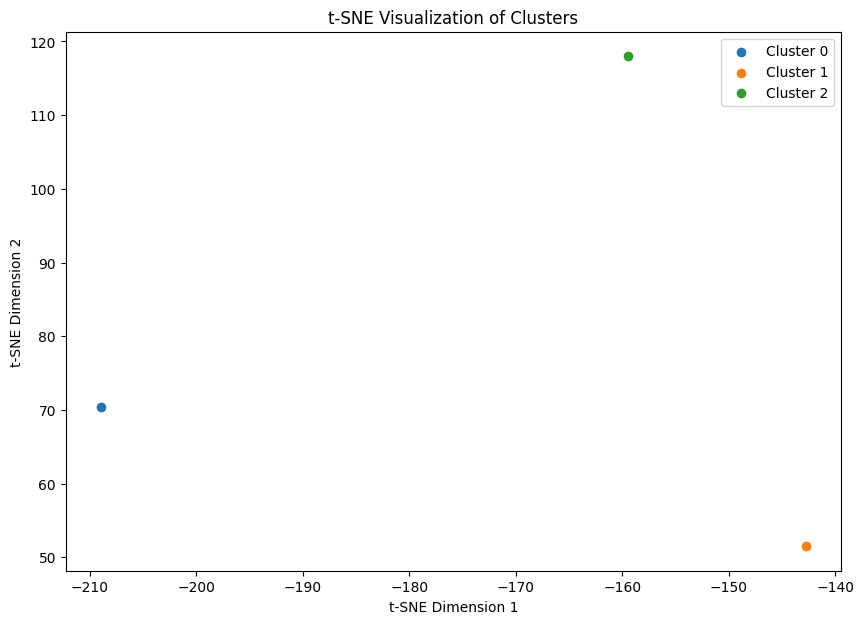

In [15]:
#Visualize Clusters
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Use a perplexity value less than the number of samples (n_samples)
tsne = TSNE(n_components=2, perplexity=2, random_state=42)
vision_embeddings_tsne = tsne.fit_transform(vision_embeddings_pca)

# Plot the clusters
plt.figure(figsize=(10, 7))
for cluster_id in set(clusters):
    cluster_points = vision_embeddings_tsne[clusters == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
plt.legend()
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

Cluster 0:


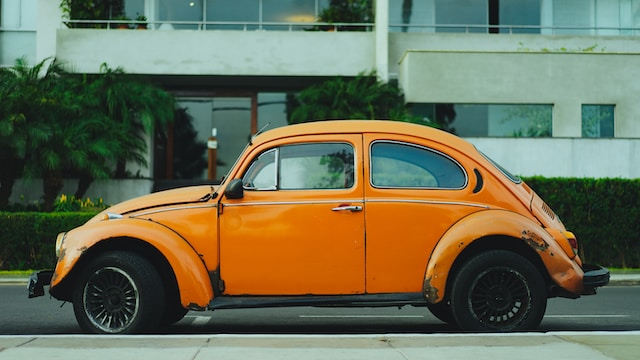

Cluster 1:


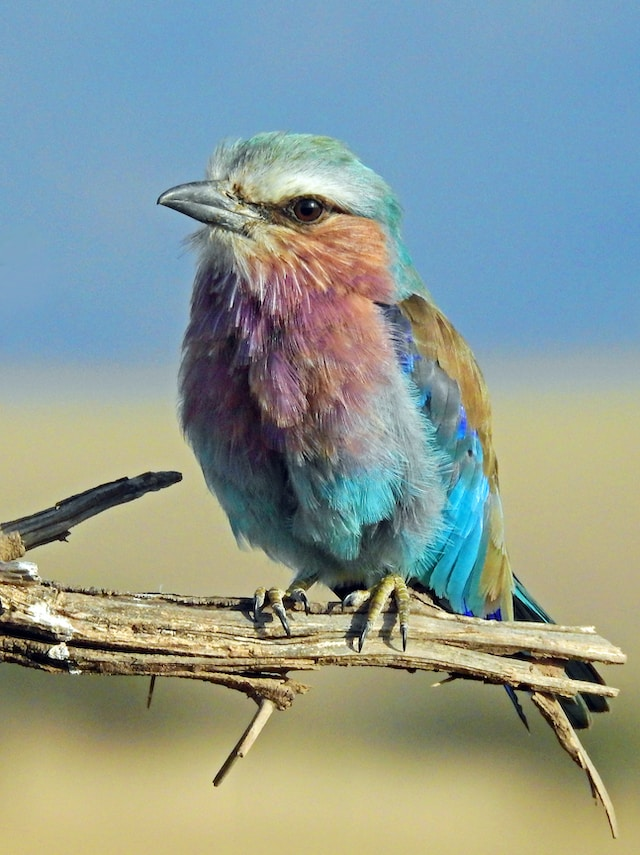

Cluster 2:


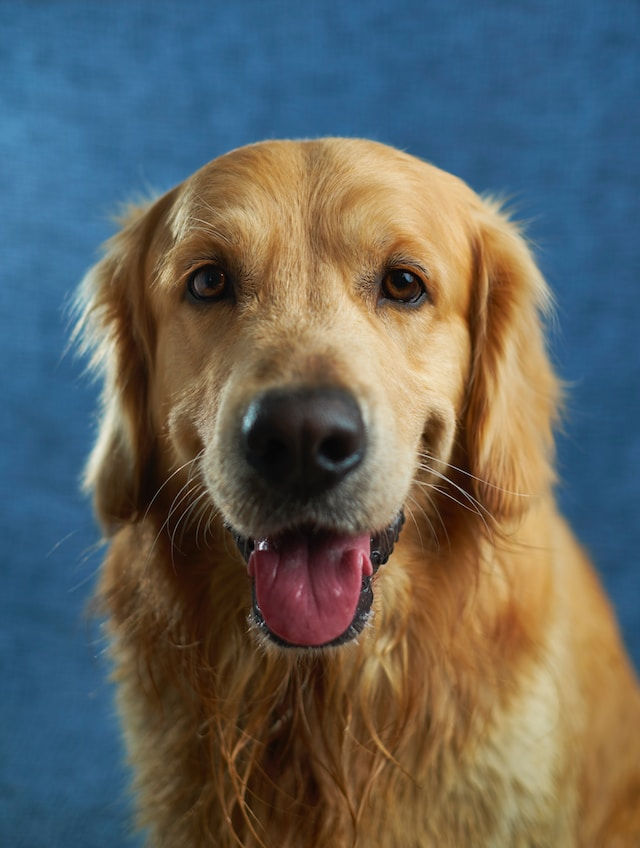

In [16]:
#Analyze Results
from PIL import Image

# Group images by cluster
cluster_to_images = {i: [] for i in range(len(set(clusters)))}
for idx, cluster_id in enumerate(clusters):
    cluster_to_images[cluster_id].append(image_paths[idx])

# Display images in each cluster
for cluster_id, images in cluster_to_images.items():
    print(f"Cluster {cluster_id}:")
    for img_path in images:
        display(Image.open(img_path))

In [17]:
#Explore Combined Modalities
import numpy as np

# Combine vision and text embeddings
combined_embeddings = np.hstack([vision_embeddings, text_embeddings])

# Perform PCA on combined embeddings
pca = PCA(n_components=min(3, combined_embeddings.shape[1]))
combined_embeddings_pca = pca.fit_transform(combined_embeddings)

# Perform KMeans clustering
kmeans_combined = KMeans(n_clusters=3, random_state=42).fit_predict(combined_embeddings_pca)

print("Combined clustering complete!")

Combined clustering complete!


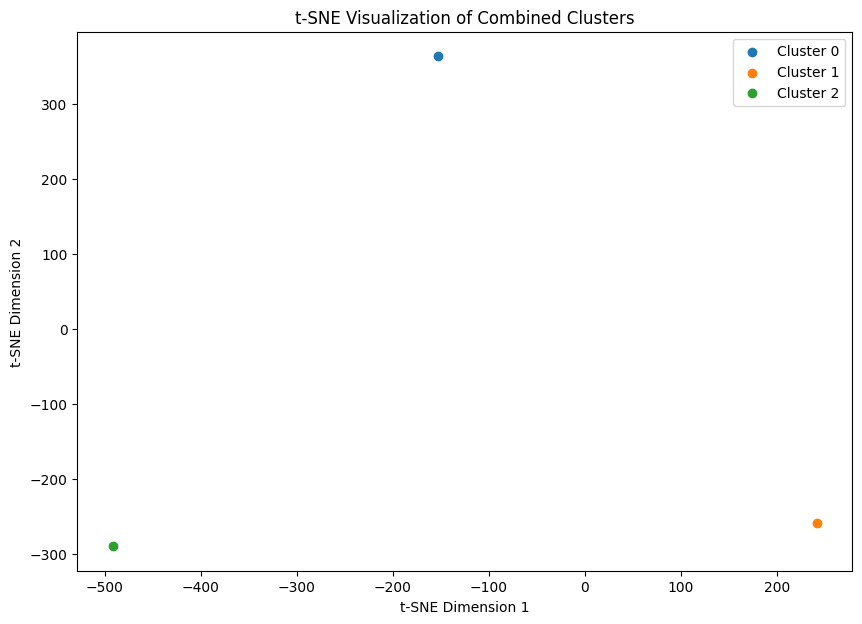

In [18]:
#Visualize Combined Clusters
tsne = TSNE(n_components=2, perplexity=2, random_state=42)
combined_embeddings_tsne = tsne.fit_transform(combined_embeddings_pca)

plt.figure(figsize=(10, 7))
for cluster_id in set(kmeans_combined):
    cluster_points = combined_embeddings_tsne[kmeans_combined == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}")
plt.legend()
plt.title("t-SNE Visualization of Combined Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


In [19]:
#save output
import pickle

# Save embeddings
with open("vision_embeddings.pkl", "wb") as f:
    pickle.dump(vision_embeddings, f)

with open("combined_embeddings.pkl", "wb") as f:
    pickle.dump(combined_embeddings, f)

# Save cluster labels
with open("clusters.pkl", "wb") as f:
    pickle.dump(clusters, f)

print("Embeddings and cluster labels saved successfully!")


Embeddings and cluster labels saved successfully!


In [20]:
#Load Data for Cross-Modality
# Assuming vision_embeddings and text_embeddings are already generated
print("Vision Embeddings Shape:", vision_embeddings.shape)
print("Text Embeddings Shape:", text_embeddings.shape)

Vision Embeddings Shape: (3, 1024)
Text Embeddings Shape: (3, 1024)


In [21]:
#Calculate Cross-Modality Similarity
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity between vision and text embeddings
vision_text_similarity = cosine_similarity(vision_embeddings, text_embeddings)

# Print similarity matrix
print("Vision-Text Similarity Matrix:")
print(vision_text_similarity)

Vision-Text Similarity Matrix:
[[0.21722375 0.17620708 0.12774158]
 [0.10637736 0.22926635 0.12294154]
 [0.12335423 0.19270957 0.23562677]]


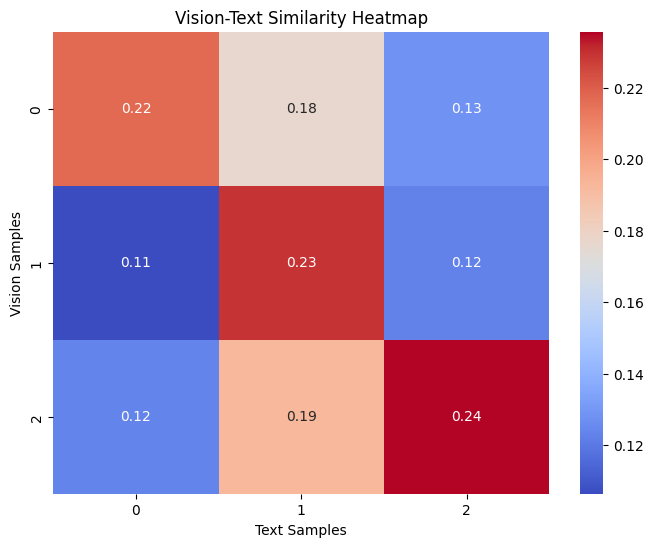

In [24]:
#Visualize Similarities
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(vision_text_similarity, annot=True, cmap="coolwarm", cbar=True)
plt.title("Vision-Text Similarity Heatmap")
plt.xlabel("Text Samples")
plt.ylabel("Vision Samples")
plt.show()